In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
from keras.constraints import Constraint
import pickle

In [3]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 401.8727
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.9537
t_final = 0.005
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

num_step = 10

In [4]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As

In [5]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 772
shape of x_deviation is (772, 2)


In [6]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
          C_A_list.append(C_A - C_As)  # in deviation form
          T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [7]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [8]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

(12352,)
(12352, 10)


In [9]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

CA0_input_neg = -np.array(CA0_input)
CA0_input_neg = CA0_input_neg.reshape(-1,1,1)

Q_input_neg = -np.array(Q_input)
Q_input_neg = Q_input_neg.reshape(-1,1,1)

CA_input_neg = -np.array(CA_input)
CA_input_neg = CA_input_neg.reshape(-1,1,1)

T_input_neg = -np.array(T_input)
T_input_neg = T_input_neg.reshape(-1,1,1)

RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""

RNN_input = RNN_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12352, 10, 4)


In [10]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]
[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]


In [11]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, num_step, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_step, 1)

RNN_output = np.concatenate((T_output, CA_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12352, 10, 2)


In [12]:
# checking output
print(RNN_output[0, :5])

[[-74.82498608   1.43869052]
 [-75.94937347   1.43097798]
 [-77.07255531   1.4233169 ]
 [-78.19443649   1.41570516]
 [-79.31492759   1.4081408 ]]


In [17]:
# set the seed for reproducibility
tf.random.set_seed(42)

training_loss = [0]*10
test_loss = [0]*10
noise = 0
for i in range(10):
  num_dims = 4

  # split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

  # # define scalers for both X and y base on training data only
  scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, num_dims))
  scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))

  X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
  X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
  y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)
  y_test_normalized = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,num_step,2)

  y_train = y_train + np.random.normal(0, noise, y_train.shape)

  model = Sequential()
  model.add(LSTM(128, activation='relu', return_sequences=True))
  model.add(LSTM(128, activation='relu', return_sequences=True))
  model.add(Dense(2, activation='linear'))

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
  history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_split=0.25, verbose=2)
  training_loss[i] = history.history['val_loss'][-1]
  print(noise)
  print(training_loss)

  loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
  test_loss[i] = loss[0]
  print(test_loss)

  name = 'lstm_128_'
  name = name + str(noise) + '.h5'
  model.save(name)

  noise = noise + 0.1

model.summary()

Epoch 1/200
26/26 - 4s - loss: 0.5772 - mean_squared_error: 0.5772 - val_loss: 0.3185 - val_mean_squared_error: 0.3185 - 4s/epoch - 167ms/step
Epoch 2/200
26/26 - 3s - loss: 0.2337 - mean_squared_error: 0.2337 - val_loss: 0.1528 - val_mean_squared_error: 0.1528 - 3s/epoch - 110ms/step
Epoch 3/200
26/26 - 3s - loss: 0.1183 - mean_squared_error: 0.1183 - val_loss: 0.0858 - val_mean_squared_error: 0.0858 - 3s/epoch - 110ms/step
Epoch 4/200
26/26 - 3s - loss: 0.0686 - mean_squared_error: 0.0686 - val_loss: 0.0514 - val_mean_squared_error: 0.0514 - 3s/epoch - 110ms/step
Epoch 5/200
26/26 - 3s - loss: 0.0415 - mean_squared_error: 0.0415 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - 3s/epoch - 110ms/step
Epoch 6/200
26/26 - 3s - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - 3s/epoch - 108ms/step
Epoch 7/200
26/26 - 3s - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - 3s/epoch - 109ms/step

Epoch 55/200
26/26 - 3s - loss: 6.2728e-05 - mean_squared_error: 6.2728e-05 - val_loss: 6.2945e-05 - val_mean_squared_error: 6.2945e-05 - 3s/epoch - 113ms/step
Epoch 56/200
26/26 - 3s - loss: 6.3155e-05 - mean_squared_error: 6.3155e-05 - val_loss: 7.7453e-05 - val_mean_squared_error: 7.7453e-05 - 3s/epoch - 113ms/step
Epoch 57/200
26/26 - 3s - loss: 8.1716e-05 - mean_squared_error: 8.1716e-05 - val_loss: 5.9128e-05 - val_mean_squared_error: 5.9128e-05 - 3s/epoch - 113ms/step
Epoch 58/200
26/26 - 3s - loss: 5.6707e-05 - mean_squared_error: 5.6707e-05 - val_loss: 7.2725e-05 - val_mean_squared_error: 7.2725e-05 - 3s/epoch - 114ms/step
Epoch 59/200
26/26 - 3s - loss: 6.3665e-05 - mean_squared_error: 6.3665e-05 - val_loss: 5.5577e-05 - val_mean_squared_error: 5.5577e-05 - 3s/epoch - 114ms/step
Epoch 60/200
26/26 - 3s - loss: 6.4655e-05 - mean_squared_error: 6.4655e-05 - val_loss: 9.1072e-05 - val_mean_squared_error: 9.1072e-05 - 3s/epoch - 114ms/step
Epoch 61/200
26/26 - 3s - loss: 1.0849e-

Epoch 107/200
26/26 - 3s - loss: 4.7513e-05 - mean_squared_error: 4.7513e-05 - val_loss: 2.7106e-05 - val_mean_squared_error: 2.7106e-05 - 3s/epoch - 115ms/step
Epoch 108/200
26/26 - 3s - loss: 3.1852e-05 - mean_squared_error: 3.1852e-05 - val_loss: 2.6072e-05 - val_mean_squared_error: 2.6072e-05 - 3s/epoch - 113ms/step
Epoch 109/200
26/26 - 3s - loss: 2.9805e-05 - mean_squared_error: 2.9805e-05 - val_loss: 3.1082e-05 - val_mean_squared_error: 3.1082e-05 - 3s/epoch - 115ms/step
Epoch 110/200
26/26 - 3s - loss: 6.4881e-05 - mean_squared_error: 6.4881e-05 - val_loss: 6.5077e-05 - val_mean_squared_error: 6.5077e-05 - 3s/epoch - 113ms/step
Epoch 111/200
26/26 - 3s - loss: 4.1818e-05 - mean_squared_error: 4.1818e-05 - val_loss: 2.7857e-05 - val_mean_squared_error: 2.7857e-05 - 3s/epoch - 112ms/step
Epoch 112/200
26/26 - 3s - loss: 2.9143e-05 - mean_squared_error: 2.9143e-05 - val_loss: 2.5403e-05 - val_mean_squared_error: 2.5403e-05 - 3s/epoch - 113ms/step
Epoch 113/200
26/26 - 3s - loss: 5

Epoch 158/200
26/26 - 4s - loss: 1.5181e-05 - mean_squared_error: 1.5181e-05 - val_loss: 1.3537e-05 - val_mean_squared_error: 1.3537e-05 - 4s/epoch - 145ms/step
Epoch 159/200
26/26 - 4s - loss: 1.4160e-05 - mean_squared_error: 1.4160e-05 - val_loss: 1.4175e-05 - val_mean_squared_error: 1.4175e-05 - 4s/epoch - 146ms/step
Epoch 160/200
26/26 - 4s - loss: 1.3716e-05 - mean_squared_error: 1.3716e-05 - val_loss: 1.4110e-05 - val_mean_squared_error: 1.4110e-05 - 4s/epoch - 144ms/step
Epoch 161/200
26/26 - 4s - loss: 1.7499e-04 - mean_squared_error: 1.7499e-04 - val_loss: 8.4055e-05 - val_mean_squared_error: 8.4055e-05 - 4s/epoch - 144ms/step
Epoch 162/200
26/26 - 4s - loss: 6.6727e-05 - mean_squared_error: 6.6727e-05 - val_loss: 6.3253e-05 - val_mean_squared_error: 6.3253e-05 - 4s/epoch - 145ms/step
Epoch 163/200
26/26 - 4s - loss: 3.5921e-05 - mean_squared_error: 3.5921e-05 - val_loss: 2.6898e-05 - val_mean_squared_error: 2.6898e-05 - 4s/epoch - 146ms/step
Epoch 164/200
26/26 - 4s - loss: 2

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 - 7s - loss: 0.5391 - mean_squared_error: 0.5391 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 7s/epoch - 251ms/step
Epoch 2/200
26/26 - 4s - loss: 0.2283 - mean_squared_error: 0.2283 - val_loss: 0.1574 - val_mean_squared_error: 0.1574 - 4s/epoch - 161ms/step
Epoch 3/200
26/26 - 4s - loss: 0.1257 - mean_squared_error: 0.1257 - val_loss: 0.0945 - val_mean_squared_error: 0.0945 - 4s/epoch - 162ms/step
Epoch 4/200
26/26 - 4s - loss: 0.0785 - mean_squared_error: 0.0785 - val_loss: 0.0617 - val_mean_squared_error: 0.0617 - 4s/epoch - 161ms/step
Epoch 5/200
26/26 - 4s - loss: 0.0521 - mean_squared_error: 0.0521 - val_loss: 0.0418 - val_mean_squared_error: 0.0418 - 4s/epoch - 159ms/step
Epoch 6/200
26/26 - 4s - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - 4s/epoch - 161ms/step
Epoch 7/200
26/26 - 4s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - 4s/epoch - 161ms/step
Epoch 8/200

26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 4s/epoch - 160ms/step
Epoch 59/200
26/26 - 4s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 4s/epoch - 160ms/step
Epoch 60/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 4s/epoch - 160ms/step
Epoch 61/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 4s/epoch - 160ms/step
Epoch 62/200
26/26 - 4s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 4s/epoch - 160ms/step
Epoch 63/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 4s/epoch - 160ms/step
Epoch 64/200
26/26 - 4s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 4s/epoch - 160ms/step
Epoch

Epoch 115/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 4s/epoch - 161ms/step
Epoch 116/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 4s/epoch - 160ms/step
Epoch 117/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 4s/epoch - 161ms/step
Epoch 118/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 4s/epoch - 162ms/step
Epoch 119/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 4s/epoch - 162ms/step
Epoch 120/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 4s/epoch - 162ms/step
Epoch 121/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 4s/epoc

Epoch 172/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 4s/epoch - 151ms/step
Epoch 173/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 4s/epoch - 148ms/step
Epoch 174/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 4s/epoch - 147ms/step
Epoch 175/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 4s/epoch - 154ms/step
Epoch 176/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 4s/epoch - 160ms/step
Epoch 177/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 4s/epoch - 149ms/step
Epoch 178/200
26/26 - 4s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 4s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 - 5s - loss: 0.6479 - mean_squared_error: 0.6479 - val_loss: 0.3758 - val_mean_squared_error: 0.3758 - 5s/epoch - 210ms/step
Epoch 2/200
26/26 - 4s - loss: 0.2885 - mean_squared_error: 0.2885 - val_loss: 0.2033 - val_mean_squared_error: 0.2033 - 4s/epoch - 140ms/step
Epoch 3/200
26/26 - 4s - loss: 0.1677 - mean_squared_error: 0.1677 - val_loss: 0.1337 - val_mean_squared_error: 0.1337 - 4s/epoch - 141ms/step
Epoch 4/200
26/26 - 4s - loss: 0.1162 - mean_squared_error: 0.1162 - val_loss: 0.0987 - val_mean_squared_error: 0.0987 - 4s/epoch - 141ms/step
Epoch 5/200
26/26 - 4s - loss: 0.0887 - mean_squared_error: 0.0887 - val_loss: 0.0783 - val_mean_squared_error: 0.0783 - 4s/epoch - 143ms/step
Epoch 6/200
26/26 - 4s - loss: 0.0709 - mean_squared_error: 0.0709 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 4s/epoch - 140ms/step
Epoch 7/200
26/26 - 4s - loss: 0.0586 - mean_squared_error: 0.0586 - val_loss: 0.0541 - val_mean_squared_error: 0.0541 - 4s/epoch - 140ms/step
Epoch 8/200

26/26 - 4s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 4s/epoch - 142ms/step
Epoch 59/200
26/26 - 4s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - 4s/epoch - 142ms/step
Epoch 60/200
26/26 - 4s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 4s/epoch - 139ms/step
Epoch 61/200
26/26 - 4s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 4s/epoch - 140ms/step
Epoch 62/200
26/26 - 4s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 4s/epoch - 141ms/step
Epoch 63/200
26/26 - 4s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - 4s/epoch - 143ms/step
Epoch 64/200
26/26 - 4s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - 4s/epoch - 142ms/step
Epoch

Epoch 115/200
26/26 - 6s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 6s/epoch - 219ms/step
Epoch 116/200
26/26 - 6s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 6s/epoch - 220ms/step
Epoch 117/200
26/26 - 6s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 6s/epoch - 216ms/step
Epoch 118/200
26/26 - 6s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 6s/epoch - 219ms/step
Epoch 119/200
26/26 - 6s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 6s/epoch - 221ms/step
Epoch 120/200
26/26 - 6s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 6s/epoch - 218ms/step
Epoch 121/200
26/26 - 6s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - 6s/epoc

Epoch 172/200
26/26 - 8s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 8s/epoch - 305ms/step
Epoch 173/200
26/26 - 8s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - 8s/epoch - 308ms/step
Epoch 174/200
26/26 - 8s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 8s/epoch - 311ms/step
Epoch 175/200
26/26 - 8s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 8s/epoch - 308ms/step
Epoch 176/200
26/26 - 8s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 8s/epoch - 306ms/step
Epoch 177/200
26/26 - 8s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 8s/epoch - 305ms/step
Epoch 178/200
26/26 - 8s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 8s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 24s - loss: 0.6933 - mean_squared_error: 0.6933 - val_loss: 0.4218 - val_mean_squared_error: 0.4218 - 24s/epoch - 933ms/step
Epoch 2/200
26/26 - 8s - loss: 0.3362 - mean_squared_error: 0.3362 - val_loss: 0.2535 - val_mean_squared_error: 0.2535 - 8s/epoch - 295ms/step
Epoch 3/200
26/26 - 7s - loss: 0.2180 - mean_squared_error: 0.2180 - val_loss: 0.1838 - val_mean_squared_error: 0.1838 - 7s/epoch - 288ms/step
Epoch 4/200
26/26 - 8s - loss: 0.1648 - mean_squared_error: 0.1648 - val_loss: 0.1455 - val_mean_squared_error: 0.1455 - 8s/epoch - 292ms/step
Epoch 5/200
26/26 - 8s - loss: 0.1352 - mean_squared_error: 0.1352 - val_loss: 0.1241 - val_mean_squared_error: 0.1241 - 8s/epoch - 291ms/step
Epoch 6/200
26/26 - 8s - loss: 0.1167 - mean_squared_error: 0.1167 - val_loss: 0.1087 - val_mean_squared_error: 0.1087 - 8s/epoch - 291ms/step
Epoch 7/200
26/26 - 7s - loss: 0.1046 - mean_squared_error: 0.1046 - val_loss: 0.1009 - val_mean_squared_error: 0.1009 - 7s/epoch - 288ms/st

Epoch 58/200
26/26 - 8s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 8s/epoch - 290ms/step
Epoch 59/200
26/26 - 7s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - 7s/epoch - 288ms/step
Epoch 60/200
26/26 - 7s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - 7s/epoch - 287ms/step
Epoch 61/200
26/26 - 8s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 8s/epoch - 290ms/step
Epoch 62/200
26/26 - 8s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 8s/epoch - 289ms/step
Epoch 63/200
26/26 - 8s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 8s/epoch - 290ms/step
Epoch 64/200
26/26 - 8s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 8s/epoch - 291

Epoch 115/200
26/26 - 8s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 8s/epoch - 290ms/step
Epoch 116/200
26/26 - 8s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 8s/epoch - 291ms/step
Epoch 117/200
26/26 - 8s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 8s/epoch - 289ms/step
Epoch 118/200
26/26 - 8s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 8s/epoch - 292ms/step
Epoch 119/200
26/26 - 8s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 8s/epoch - 290ms/step
Epoch 120/200
26/26 - 8s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 8s/epoch - 291ms/step
Epoch 121/200
26/26 - 8s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 8s/epoc

Epoch 172/200
26/26 - 7s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 7s/epoch - 288ms/step
Epoch 173/200
26/26 - 8s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 8s/epoch - 289ms/step
Epoch 174/200
26/26 - 8s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 8s/epoch - 290ms/step
Epoch 175/200
26/26 - 8s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 8s/epoch - 289ms/step
Epoch 176/200
26/26 - 7s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 7s/epoch - 287ms/step
Epoch 177/200
26/26 - 7s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0914 - val_mean_squared_error: 0.0914 - 7s/epoch - 287ms/step
Epoch 178/200
26/26 - 7s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 7s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 26s - loss: 0.7314 - mean_squared_error: 0.7314 - val_loss: 0.4764 - val_mean_squared_error: 0.4764 - 26s/epoch - 1s/step
Epoch 2/200
26/26 - 6s - loss: 0.3910 - mean_squared_error: 0.3910 - val_loss: 0.3144 - val_mean_squared_error: 0.3144 - 6s/epoch - 236ms/step
Epoch 3/200
26/26 - 6s - loss: 0.2813 - mean_squared_error: 0.2813 - val_loss: 0.2517 - val_mean_squared_error: 0.2517 - 6s/epoch - 231ms/step
Epoch 4/200
26/26 - 6s - loss: 0.2309 - mean_squared_error: 0.2309 - val_loss: 0.2165 - val_mean_squared_error: 0.2165 - 6s/epoch - 229ms/step
Epoch 5/200
26/26 - 6s - loss: 0.2037 - mean_squared_error: 0.2037 - val_loss: 0.1963 - val_mean_squared_error: 0.1963 - 6s/epoch - 232ms/step
Epoch 6/200
26/26 - 6s - loss: 0.1874 - mean_squared_error: 0.1874 - val_loss: 0.1827 - val_mean_squared_error: 0.1827 - 6s/epoch - 231ms/step
Epoch 7/200
26/26 - 6s - loss: 0.1761 - mean_squared_error: 0.1761 - val_loss: 0.1739 - val_mean_squared_error: 0.1739 - 6s/epoch - 231ms/step


Epoch 58/200
26/26 - 6s - loss: 0.1604 - mean_squared_error: 0.1604 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - 6s/epoch - 246ms/step
Epoch 59/200
26/26 - 6s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1632 - val_mean_squared_error: 0.1632 - 6s/epoch - 246ms/step
Epoch 60/200
26/26 - 6s - loss: 0.1601 - mean_squared_error: 0.1601 - val_loss: 0.1638 - val_mean_squared_error: 0.1638 - 6s/epoch - 245ms/step
Epoch 61/200
26/26 - 6s - loss: 0.1603 - mean_squared_error: 0.1603 - val_loss: 0.1639 - val_mean_squared_error: 0.1639 - 6s/epoch - 245ms/step
Epoch 62/200
26/26 - 6s - loss: 0.1603 - mean_squared_error: 0.1603 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - 6s/epoch - 246ms/step
Epoch 63/200
26/26 - 6s - loss: 0.1604 - mean_squared_error: 0.1604 - val_loss: 0.1632 - val_mean_squared_error: 0.1632 - 6s/epoch - 247ms/step
Epoch 64/200
26/26 - 6s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1632 - val_mean_squared_error: 0.1632 - 6s/epoch - 244

Epoch 115/200
26/26 - 7s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1637 - val_mean_squared_error: 0.1637 - 7s/epoch - 277ms/step
Epoch 116/200
26/26 - 7s - loss: 0.1601 - mean_squared_error: 0.1601 - val_loss: 0.1640 - val_mean_squared_error: 0.1640 - 7s/epoch - 272ms/step
Epoch 117/200
26/26 - 7s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1631 - val_mean_squared_error: 0.1631 - 7s/epoch - 270ms/step
Epoch 118/200
26/26 - 7s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1638 - val_mean_squared_error: 0.1638 - 7s/epoch - 285ms/step
Epoch 119/200
26/26 - 7s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1638 - val_mean_squared_error: 0.1638 - 7s/epoch - 280ms/step
Epoch 120/200
26/26 - 7s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1637 - val_mean_squared_error: 0.1637 - 7s/epoch - 281ms/step
Epoch 121/200
26/26 - 7s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1637 - val_mean_squared_error: 0.1637 - 7s/epoc

Epoch 172/200
26/26 - 11s - loss: 0.1592 - mean_squared_error: 0.1592 - val_loss: 0.1638 - val_mean_squared_error: 0.1638 - 11s/epoch - 416ms/step
Epoch 173/200
26/26 - 11s - loss: 0.1592 - mean_squared_error: 0.1592 - val_loss: 0.1638 - val_mean_squared_error: 0.1638 - 11s/epoch - 413ms/step
Epoch 174/200
26/26 - 11s - loss: 0.1591 - mean_squared_error: 0.1591 - val_loss: 0.1635 - val_mean_squared_error: 0.1635 - 11s/epoch - 408ms/step
Epoch 175/200
26/26 - 11s - loss: 0.1591 - mean_squared_error: 0.1591 - val_loss: 0.1636 - val_mean_squared_error: 0.1636 - 11s/epoch - 420ms/step
Epoch 176/200
26/26 - 11s - loss: 0.1593 - mean_squared_error: 0.1593 - val_loss: 0.1639 - val_mean_squared_error: 0.1639 - 11s/epoch - 416ms/step
Epoch 177/200
26/26 - 11s - loss: 0.1593 - mean_squared_error: 0.1593 - val_loss: 0.1637 - val_mean_squared_error: 0.1637 - 11s/epoch - 412ms/step
Epoch 178/200
26/26 - 11s - loss: 0.1592 - mean_squared_error: 0.1592 - val_loss: 0.1641 - val_mean_squared_error: 0.1

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 375s - loss: 0.8319 - mean_squared_error: 0.8319 - val_loss: 0.5723 - val_mean_squared_error: 0.5723 - 375s/epoch - 14s/step
Epoch 2/200
26/26 - 6s - loss: 0.4988 - mean_squared_error: 0.4988 - val_loss: 0.4202 - val_mean_squared_error: 0.4202 - 6s/epoch - 230ms/step
Epoch 3/200
26/26 - 6s - loss: 0.3835 - mean_squared_error: 0.3835 - val_loss: 0.3491 - val_mean_squared_error: 0.3491 - 6s/epoch - 225ms/step
Epoch 4/200
26/26 - 6s - loss: 0.3307 - mean_squared_error: 0.3307 - val_loss: 0.3121 - val_mean_squared_error: 0.3121 - 6s/epoch - 216ms/step
Epoch 5/200
26/26 - 6s - loss: 0.3013 - mean_squared_error: 0.3013 - val_loss: 0.2909 - val_mean_squared_error: 0.2909 - 6s/epoch - 233ms/step
Epoch 6/200
26/26 - 6s - loss: 0.2829 - mean_squared_error: 0.2829 - val_loss: 0.2777 - val_mean_squared_error: 0.2777 - 6s/epoch - 230ms/step
Epoch 7/200
26/26 - 6s - loss: 0.2712 - mean_squared_error: 0.2712 - val_loss: 0.2669 - val_mean_squared_error: 0.2669 - 6s/epoch - 228ms/st

Epoch 58/200
26/26 - 7s - loss: 0.2504 - mean_squared_error: 0.2504 - val_loss: 0.2524 - val_mean_squared_error: 0.2524 - 7s/epoch - 255ms/step
Epoch 59/200
26/26 - 7s - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.2528 - val_mean_squared_error: 0.2528 - 7s/epoch - 281ms/step
Epoch 60/200
26/26 - 7s - loss: 0.2500 - mean_squared_error: 0.2500 - val_loss: 0.2527 - val_mean_squared_error: 0.2527 - 7s/epoch - 265ms/step
Epoch 61/200
26/26 - 7s - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.2526 - val_mean_squared_error: 0.2526 - 7s/epoch - 274ms/step
Epoch 62/200
26/26 - 7s - loss: 0.2508 - mean_squared_error: 0.2508 - val_loss: 0.2541 - val_mean_squared_error: 0.2541 - 7s/epoch - 278ms/step
Epoch 63/200
26/26 - 7s - loss: 0.2505 - mean_squared_error: 0.2505 - val_loss: 0.2526 - val_mean_squared_error: 0.2526 - 7s/epoch - 262ms/step
Epoch 64/200
26/26 - 7s - loss: 0.2501 - mean_squared_error: 0.2501 - val_loss: 0.2525 - val_mean_squared_error: 0.2525 - 7s/epoch - 287

Epoch 115/200
26/26 - 6s - loss: 0.2494 - mean_squared_error: 0.2494 - val_loss: 0.2530 - val_mean_squared_error: 0.2530 - 6s/epoch - 243ms/step
Epoch 116/200
26/26 - 6s - loss: 0.2496 - mean_squared_error: 0.2496 - val_loss: 0.2527 - val_mean_squared_error: 0.2527 - 6s/epoch - 242ms/step
Epoch 117/200
26/26 - 6s - loss: 0.2496 - mean_squared_error: 0.2496 - val_loss: 0.2534 - val_mean_squared_error: 0.2534 - 6s/epoch - 235ms/step
Epoch 118/200
26/26 - 6s - loss: 0.2495 - mean_squared_error: 0.2495 - val_loss: 0.2528 - val_mean_squared_error: 0.2528 - 6s/epoch - 239ms/step
Epoch 119/200
26/26 - 6s - loss: 0.2494 - mean_squared_error: 0.2494 - val_loss: 0.2535 - val_mean_squared_error: 0.2535 - 6s/epoch - 232ms/step
Epoch 120/200
26/26 - 6s - loss: 0.2494 - mean_squared_error: 0.2494 - val_loss: 0.2531 - val_mean_squared_error: 0.2531 - 6s/epoch - 233ms/step
Epoch 121/200
26/26 - 6s - loss: 0.2493 - mean_squared_error: 0.2493 - val_loss: 0.2531 - val_mean_squared_error: 0.2531 - 6s/epoc

Epoch 172/200
26/26 - 5s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2536 - val_mean_squared_error: 0.2536 - 5s/epoch - 205ms/step
Epoch 173/200
26/26 - 5s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2536 - val_mean_squared_error: 0.2536 - 5s/epoch - 207ms/step
Epoch 174/200
26/26 - 6s - loss: 0.2488 - mean_squared_error: 0.2488 - val_loss: 0.2531 - val_mean_squared_error: 0.2531 - 6s/epoch - 217ms/step
Epoch 175/200
26/26 - 6s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2532 - val_mean_squared_error: 0.2532 - 6s/epoch - 232ms/step
Epoch 176/200
26/26 - 6s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - 6s/epoch - 231ms/step
Epoch 177/200
26/26 - 6s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2538 - val_mean_squared_error: 0.2538 - 6s/epoch - 233ms/step
Epoch 178/200
26/26 - 6s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2536 - val_mean_squared_error: 0.2536 - 6s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 406s - loss: 0.9150 - mean_squared_error: 0.9150 - val_loss: 0.6648 - val_mean_squared_error: 0.6648 - 406s/epoch - 16s/step
Epoch 2/200
26/26 - 8s - loss: 0.5827 - mean_squared_error: 0.5827 - val_loss: 0.5112 - val_mean_squared_error: 0.5112 - 8s/epoch - 307ms/step
Epoch 3/200
26/26 - 8s - loss: 0.4772 - mean_squared_error: 0.4772 - val_loss: 0.4481 - val_mean_squared_error: 0.4481 - 8s/epoch - 321ms/step
Epoch 4/200
26/26 - 8s - loss: 0.4314 - mean_squared_error: 0.4314 - val_loss: 0.4120 - val_mean_squared_error: 0.4120 - 8s/epoch - 289ms/step
Epoch 5/200
26/26 - 7s - loss: 0.4055 - mean_squared_error: 0.4055 - val_loss: 0.3931 - val_mean_squared_error: 0.3931 - 7s/epoch - 284ms/step
Epoch 6/200
26/26 - 9s - loss: 0.3875 - mean_squared_error: 0.3875 - val_loss: 0.3789 - val_mean_squared_error: 0.3789 - 9s/epoch - 330ms/step
Epoch 7/200
26/26 - 8s - loss: 0.3770 - mean_squared_error: 0.3770 - val_loss: 0.3695 - val_mean_squared_error: 0.3695 - 8s/epoch - 296ms/st

Epoch 58/200
26/26 - 6s - loss: 0.3592 - mean_squared_error: 0.3592 - val_loss: 0.3586 - val_mean_squared_error: 0.3586 - 6s/epoch - 217ms/step
Epoch 59/200
26/26 - 5s - loss: 0.3589 - mean_squared_error: 0.3589 - val_loss: 0.3580 - val_mean_squared_error: 0.3580 - 5s/epoch - 197ms/step
Epoch 60/200
26/26 - 5s - loss: 0.3589 - mean_squared_error: 0.3589 - val_loss: 0.3584 - val_mean_squared_error: 0.3584 - 5s/epoch - 199ms/step
Epoch 61/200
26/26 - 5s - loss: 0.3589 - mean_squared_error: 0.3589 - val_loss: 0.3582 - val_mean_squared_error: 0.3582 - 5s/epoch - 179ms/step
Epoch 62/200
26/26 - 5s - loss: 0.3591 - mean_squared_error: 0.3591 - val_loss: 0.3581 - val_mean_squared_error: 0.3581 - 5s/epoch - 178ms/step
Epoch 63/200
26/26 - 6s - loss: 0.3589 - mean_squared_error: 0.3589 - val_loss: 0.3584 - val_mean_squared_error: 0.3584 - 6s/epoch - 234ms/step
Epoch 64/200
26/26 - 6s - loss: 0.3591 - mean_squared_error: 0.3591 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 6s/epoch - 231

Epoch 115/200
26/26 - 9s - loss: 0.3580 - mean_squared_error: 0.3580 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - 9s/epoch - 364ms/step
Epoch 116/200
26/26 - 9s - loss: 0.3576 - mean_squared_error: 0.3576 - val_loss: 0.3584 - val_mean_squared_error: 0.3584 - 9s/epoch - 355ms/step
Epoch 117/200
26/26 - 9s - loss: 0.3578 - mean_squared_error: 0.3578 - val_loss: 0.3593 - val_mean_squared_error: 0.3593 - 9s/epoch - 362ms/step
Epoch 118/200
26/26 - 10s - loss: 0.3582 - mean_squared_error: 0.3582 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - 10s/epoch - 396ms/step
Epoch 119/200
26/26 - 9s - loss: 0.3577 - mean_squared_error: 0.3577 - val_loss: 0.3598 - val_mean_squared_error: 0.3598 - 9s/epoch - 363ms/step
Epoch 120/200
26/26 - 9s - loss: 0.3580 - mean_squared_error: 0.3580 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 9s/epoch - 356ms/step
Epoch 121/200
26/26 - 10s - loss: 0.3580 - mean_squared_error: 0.3580 - val_loss: 0.3600 - val_mean_squared_error: 0.3600 - 10s/

Epoch 172/200
26/26 - 8s - loss: 0.3565 - mean_squared_error: 0.3565 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 8s/epoch - 294ms/step
Epoch 173/200
26/26 - 8s - loss: 0.3562 - mean_squared_error: 0.3562 - val_loss: 0.3594 - val_mean_squared_error: 0.3594 - 8s/epoch - 291ms/step
Epoch 174/200
26/26 - 8s - loss: 0.3564 - mean_squared_error: 0.3564 - val_loss: 0.3603 - val_mean_squared_error: 0.3603 - 8s/epoch - 294ms/step
Epoch 175/200
26/26 - 8s - loss: 0.3563 - mean_squared_error: 0.3563 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 8s/epoch - 297ms/step
Epoch 176/200
26/26 - 8s - loss: 0.3565 - mean_squared_error: 0.3565 - val_loss: 0.3623 - val_mean_squared_error: 0.3623 - 8s/epoch - 295ms/step
Epoch 177/200
26/26 - 8s - loss: 0.3570 - mean_squared_error: 0.3570 - val_loss: 0.3609 - val_mean_squared_error: 0.3609 - 8s/epoch - 296ms/step
Epoch 178/200
26/26 - 8s - loss: 0.3566 - mean_squared_error: 0.3566 - val_loss: 0.3613 - val_mean_squared_error: 0.3613 - 8s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 483s - loss: 1.0220 - mean_squared_error: 1.0220 - val_loss: 0.7888 - val_mean_squared_error: 0.7888 - 483s/epoch - 19s/step
Epoch 2/200
26/26 - 7s - loss: 0.7117 - mean_squared_error: 0.7117 - val_loss: 0.6404 - val_mean_squared_error: 0.6404 - 7s/epoch - 272ms/step
Epoch 3/200
26/26 - 7s - loss: 0.6134 - mean_squared_error: 0.6134 - val_loss: 0.5824 - val_mean_squared_error: 0.5824 - 7s/epoch - 272ms/step
Epoch 4/200
26/26 - 7s - loss: 0.5682 - mean_squared_error: 0.5682 - val_loss: 0.5486 - val_mean_squared_error: 0.5486 - 7s/epoch - 274ms/step
Epoch 5/200
26/26 - 7s - loss: 0.5430 - mean_squared_error: 0.5430 - val_loss: 0.5290 - val_mean_squared_error: 0.5290 - 7s/epoch - 273ms/step
Epoch 6/200
26/26 - 7s - loss: 0.5276 - mean_squared_error: 0.5276 - val_loss: 0.5176 - val_mean_squared_error: 0.5176 - 7s/epoch - 273ms/step
Epoch 7/200
26/26 - 7s - loss: 0.5151 - mean_squared_error: 0.5151 - val_loss: 0.5051 - val_mean_squared_error: 0.5051 - 7s/epoch - 281ms/st

Epoch 58/200
26/26 - 7s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4901 - val_mean_squared_error: 0.4901 - 7s/epoch - 260ms/step
Epoch 59/200
26/26 - 7s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4909 - val_mean_squared_error: 0.4909 - 7s/epoch - 262ms/step
Epoch 60/200
26/26 - 7s - loss: 0.4925 - mean_squared_error: 0.4925 - val_loss: 0.4901 - val_mean_squared_error: 0.4901 - 7s/epoch - 264ms/step
Epoch 61/200
26/26 - 8s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4901 - val_mean_squared_error: 0.4901 - 8s/epoch - 302ms/step
Epoch 62/200
26/26 - 8s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4896 - val_mean_squared_error: 0.4896 - 8s/epoch - 299ms/step
Epoch 63/200
26/26 - 8s - loss: 0.4916 - mean_squared_error: 0.4916 - val_loss: 0.4900 - val_mean_squared_error: 0.4900 - 8s/epoch - 297ms/step
Epoch 64/200
26/26 - 8s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4895 - val_mean_squared_error: 0.4895 - 8s/epoch - 296

Epoch 115/200
26/26 - 7s - loss: 0.4902 - mean_squared_error: 0.4902 - val_loss: 0.4905 - val_mean_squared_error: 0.4905 - 7s/epoch - 280ms/step
Epoch 116/200
26/26 - 7s - loss: 0.4904 - mean_squared_error: 0.4904 - val_loss: 0.4906 - val_mean_squared_error: 0.4906 - 7s/epoch - 287ms/step
Epoch 117/200
26/26 - 7s - loss: 0.4901 - mean_squared_error: 0.4901 - val_loss: 0.4906 - val_mean_squared_error: 0.4906 - 7s/epoch - 282ms/step
Epoch 118/200
26/26 - 7s - loss: 0.4902 - mean_squared_error: 0.4902 - val_loss: 0.4907 - val_mean_squared_error: 0.4907 - 7s/epoch - 285ms/step
Epoch 119/200
26/26 - 7s - loss: 0.4901 - mean_squared_error: 0.4901 - val_loss: 0.4901 - val_mean_squared_error: 0.4901 - 7s/epoch - 285ms/step
Epoch 120/200
26/26 - 7s - loss: 0.4903 - mean_squared_error: 0.4903 - val_loss: 0.4900 - val_mean_squared_error: 0.4900 - 7s/epoch - 283ms/step
Epoch 121/200
26/26 - 7s - loss: 0.4902 - mean_squared_error: 0.4902 - val_loss: 0.4905 - val_mean_squared_error: 0.4905 - 7s/epoc

Epoch 172/200
26/26 - 10s - loss: 0.4883 - mean_squared_error: 0.4883 - val_loss: 0.4932 - val_mean_squared_error: 0.4932 - 10s/epoch - 398ms/step
Epoch 173/200
26/26 - 8s - loss: 0.4890 - mean_squared_error: 0.4890 - val_loss: 0.4929 - val_mean_squared_error: 0.4929 - 8s/epoch - 322ms/step
Epoch 174/200
26/26 - 8s - loss: 0.4882 - mean_squared_error: 0.4882 - val_loss: 0.4917 - val_mean_squared_error: 0.4917 - 8s/epoch - 321ms/step
Epoch 175/200
26/26 - 8s - loss: 0.4884 - mean_squared_error: 0.4884 - val_loss: 0.4917 - val_mean_squared_error: 0.4917 - 8s/epoch - 313ms/step
Epoch 176/200
26/26 - 8s - loss: 0.4880 - mean_squared_error: 0.4880 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 8s/epoch - 314ms/step
Epoch 177/200
26/26 - 8s - loss: 0.4880 - mean_squared_error: 0.4880 - val_loss: 0.4935 - val_mean_squared_error: 0.4935 - 8s/epoch - 325ms/step
Epoch 178/200
26/26 - 8s - loss: 0.4884 - mean_squared_error: 0.4884 - val_loss: 0.4924 - val_mean_squared_error: 0.4924 - 8s/ep

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 231s - loss: 1.2186 - mean_squared_error: 1.2186 - val_loss: 0.9696 - val_mean_squared_error: 0.9696 - 231s/epoch - 9s/step
Epoch 2/200
26/26 - 4s - loss: 0.8890 - mean_squared_error: 0.8890 - val_loss: 0.8139 - val_mean_squared_error: 0.8139 - 4s/epoch - 155ms/step
Epoch 3/200
26/26 - 4s - loss: 0.7705 - mean_squared_error: 0.7705 - val_loss: 0.7441 - val_mean_squared_error: 0.7441 - 4s/epoch - 152ms/step
Epoch 4/200
26/26 - 4s - loss: 0.7176 - mean_squared_error: 0.7176 - val_loss: 0.7072 - val_mean_squared_error: 0.7072 - 4s/epoch - 158ms/step
Epoch 5/200
26/26 - 4s - loss: 0.6880 - mean_squared_error: 0.6880 - val_loss: 0.6833 - val_mean_squared_error: 0.6833 - 4s/epoch - 160ms/step
Epoch 6/200
26/26 - 4s - loss: 0.6693 - mean_squared_error: 0.6693 - val_loss: 0.6686 - val_mean_squared_error: 0.6686 - 4s/epoch - 158ms/step
Epoch 7/200
26/26 - 4s - loss: 0.6570 - mean_squared_error: 0.6570 - val_loss: 0.6601 - val_mean_squared_error: 0.6601 - 4s/epoch - 153ms/ste

Epoch 58/200
26/26 - 7s - loss: 0.6350 - mean_squared_error: 0.6350 - val_loss: 0.6458 - val_mean_squared_error: 0.6458 - 7s/epoch - 272ms/step
Epoch 59/200
26/26 - 7s - loss: 0.6351 - mean_squared_error: 0.6351 - val_loss: 0.6454 - val_mean_squared_error: 0.6454 - 7s/epoch - 269ms/step
Epoch 60/200
26/26 - 7s - loss: 0.6346 - mean_squared_error: 0.6346 - val_loss: 0.6456 - val_mean_squared_error: 0.6456 - 7s/epoch - 268ms/step
Epoch 61/200
26/26 - 7s - loss: 0.6350 - mean_squared_error: 0.6350 - val_loss: 0.6469 - val_mean_squared_error: 0.6469 - 7s/epoch - 270ms/step
Epoch 62/200
26/26 - 7s - loss: 0.6348 - mean_squared_error: 0.6348 - val_loss: 0.6465 - val_mean_squared_error: 0.6465 - 7s/epoch - 274ms/step
Epoch 63/200
26/26 - 8s - loss: 0.6348 - mean_squared_error: 0.6348 - val_loss: 0.6451 - val_mean_squared_error: 0.6451 - 8s/epoch - 316ms/step
Epoch 64/200
26/26 - 7s - loss: 0.6345 - mean_squared_error: 0.6345 - val_loss: 0.6449 - val_mean_squared_error: 0.6449 - 7s/epoch - 264

Epoch 115/200
26/26 - 6s - loss: 0.6324 - mean_squared_error: 0.6324 - val_loss: 0.6456 - val_mean_squared_error: 0.6456 - 6s/epoch - 221ms/step
Epoch 116/200
26/26 - 6s - loss: 0.6332 - mean_squared_error: 0.6332 - val_loss: 0.6465 - val_mean_squared_error: 0.6465 - 6s/epoch - 218ms/step
Epoch 117/200
26/26 - 6s - loss: 0.6330 - mean_squared_error: 0.6330 - val_loss: 0.6458 - val_mean_squared_error: 0.6458 - 6s/epoch - 221ms/step
Epoch 118/200
26/26 - 6s - loss: 0.6324 - mean_squared_error: 0.6324 - val_loss: 0.6458 - val_mean_squared_error: 0.6458 - 6s/epoch - 221ms/step
Epoch 119/200
26/26 - 6s - loss: 0.6324 - mean_squared_error: 0.6324 - val_loss: 0.6464 - val_mean_squared_error: 0.6464 - 6s/epoch - 239ms/step
Epoch 120/200
26/26 - 6s - loss: 0.6324 - mean_squared_error: 0.6324 - val_loss: 0.6475 - val_mean_squared_error: 0.6475 - 6s/epoch - 224ms/step
Epoch 121/200
26/26 - 7s - loss: 0.6334 - mean_squared_error: 0.6334 - val_loss: 0.6457 - val_mean_squared_error: 0.6457 - 7s/epoc

Epoch 172/200
26/26 - 8s - loss: 0.6299 - mean_squared_error: 0.6299 - val_loss: 0.6491 - val_mean_squared_error: 0.6491 - 8s/epoch - 299ms/step
Epoch 173/200
26/26 - 8s - loss: 0.6291 - mean_squared_error: 0.6291 - val_loss: 0.6492 - val_mean_squared_error: 0.6492 - 8s/epoch - 295ms/step
Epoch 174/200
26/26 - 7s - loss: 0.6289 - mean_squared_error: 0.6289 - val_loss: 0.6498 - val_mean_squared_error: 0.6498 - 7s/epoch - 275ms/step
Epoch 175/200
26/26 - 7s - loss: 0.6291 - mean_squared_error: 0.6291 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 7s/epoch - 275ms/step
Epoch 176/200
26/26 - 7s - loss: 0.6293 - mean_squared_error: 0.6293 - val_loss: 0.6491 - val_mean_squared_error: 0.6491 - 7s/epoch - 280ms/step
Epoch 177/200
26/26 - 7s - loss: 0.6292 - mean_squared_error: 0.6292 - val_loss: 0.6489 - val_mean_squared_error: 0.6489 - 7s/epoch - 276ms/step
Epoch 178/200
26/26 - 7s - loss: 0.6292 - mean_squared_error: 0.6292 - val_loss: 0.6500 - val_mean_squared_error: 0.6500 - 7s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 185s - loss: 1.4005 - mean_squared_error: 1.4005 - val_loss: 1.1411 - val_mean_squared_error: 1.1411 - 185s/epoch - 7s/step
Epoch 2/200
26/26 - 7s - loss: 1.0577 - mean_squared_error: 1.0577 - val_loss: 0.9769 - val_mean_squared_error: 0.9769 - 7s/epoch - 256ms/step
Epoch 3/200
26/26 - 7s - loss: 0.9394 - mean_squared_error: 0.9394 - val_loss: 0.9069 - val_mean_squared_error: 0.9069 - 7s/epoch - 258ms/step
Epoch 4/200
26/26 - 7s - loss: 0.8876 - mean_squared_error: 0.8876 - val_loss: 0.8729 - val_mean_squared_error: 0.8729 - 7s/epoch - 261ms/step
Epoch 5/200
26/26 - 7s - loss: 0.8617 - mean_squared_error: 0.8617 - val_loss: 0.8537 - val_mean_squared_error: 0.8537 - 7s/epoch - 252ms/step
Epoch 6/200
26/26 - 6s - loss: 0.8450 - mean_squared_error: 0.8450 - val_loss: 0.8378 - val_mean_squared_error: 0.8378 - 6s/epoch - 249ms/step
Epoch 7/200
26/26 - 7s - loss: 0.8331 - mean_squared_error: 0.8331 - val_loss: 0.8288 - val_mean_squared_error: 0.8288 - 7s/epoch - 254ms/ste

Epoch 58/200
26/26 - 7s - loss: 0.8087 - mean_squared_error: 0.8087 - val_loss: 0.8100 - val_mean_squared_error: 0.8100 - 7s/epoch - 270ms/step
Epoch 59/200
26/26 - 7s - loss: 0.8080 - mean_squared_error: 0.8080 - val_loss: 0.8106 - val_mean_squared_error: 0.8106 - 7s/epoch - 270ms/step
Epoch 60/200
26/26 - 7s - loss: 0.8085 - mean_squared_error: 0.8085 - val_loss: 0.8110 - val_mean_squared_error: 0.8110 - 7s/epoch - 274ms/step
Epoch 61/200
26/26 - 7s - loss: 0.8081 - mean_squared_error: 0.8081 - val_loss: 0.8100 - val_mean_squared_error: 0.8100 - 7s/epoch - 274ms/step
Epoch 62/200
26/26 - 7s - loss: 0.8084 - mean_squared_error: 0.8084 - val_loss: 0.8108 - val_mean_squared_error: 0.8108 - 7s/epoch - 273ms/step
Epoch 63/200
26/26 - 7s - loss: 0.8082 - mean_squared_error: 0.8082 - val_loss: 0.8114 - val_mean_squared_error: 0.8114 - 7s/epoch - 278ms/step
Epoch 64/200
26/26 - 7s - loss: 0.8083 - mean_squared_error: 0.8083 - val_loss: 0.8112 - val_mean_squared_error: 0.8112 - 7s/epoch - 278

Epoch 115/200
26/26 - 8s - loss: 0.8062 - mean_squared_error: 0.8062 - val_loss: 0.8114 - val_mean_squared_error: 0.8114 - 8s/epoch - 290ms/step
Epoch 116/200
26/26 - 7s - loss: 0.8060 - mean_squared_error: 0.8060 - val_loss: 0.8124 - val_mean_squared_error: 0.8124 - 7s/epoch - 282ms/step
Epoch 117/200
26/26 - 7s - loss: 0.8057 - mean_squared_error: 0.8057 - val_loss: 0.8141 - val_mean_squared_error: 0.8141 - 7s/epoch - 283ms/step
Epoch 118/200
26/26 - 7s - loss: 0.8051 - mean_squared_error: 0.8051 - val_loss: 0.8123 - val_mean_squared_error: 0.8123 - 7s/epoch - 282ms/step
Epoch 119/200
26/26 - 7s - loss: 0.8052 - mean_squared_error: 0.8052 - val_loss: 0.8123 - val_mean_squared_error: 0.8123 - 7s/epoch - 285ms/step
Epoch 120/200
26/26 - 8s - loss: 0.8051 - mean_squared_error: 0.8051 - val_loss: 0.8117 - val_mean_squared_error: 0.8117 - 8s/epoch - 290ms/step
Epoch 121/200
26/26 - 7s - loss: 0.8053 - mean_squared_error: 0.8053 - val_loss: 0.8120 - val_mean_squared_error: 0.8120 - 7s/epoc

Epoch 172/200
26/26 - 8s - loss: 0.8014 - mean_squared_error: 0.8014 - val_loss: 0.8163 - val_mean_squared_error: 0.8163 - 8s/epoch - 304ms/step
Epoch 173/200
26/26 - 8s - loss: 0.8018 - mean_squared_error: 0.8018 - val_loss: 0.8151 - val_mean_squared_error: 0.8151 - 8s/epoch - 299ms/step
Epoch 174/200
26/26 - 8s - loss: 0.8012 - mean_squared_error: 0.8012 - val_loss: 0.8167 - val_mean_squared_error: 0.8167 - 8s/epoch - 303ms/step
Epoch 175/200
26/26 - 8s - loss: 0.8017 - mean_squared_error: 0.8017 - val_loss: 0.8152 - val_mean_squared_error: 0.8152 - 8s/epoch - 308ms/step
Epoch 176/200
26/26 - 8s - loss: 0.8007 - mean_squared_error: 0.8007 - val_loss: 0.8158 - val_mean_squared_error: 0.8158 - 8s/epoch - 300ms/step
Epoch 177/200
26/26 - 8s - loss: 0.8012 - mean_squared_error: 0.8012 - val_loss: 0.8154 - val_mean_squared_error: 0.8154 - 8s/epoch - 304ms/step
Epoch 178/200
26/26 - 8s - loss: 0.8008 - mean_squared_error: 0.8008 - val_loss: 0.8174 - val_mean_squared_error: 0.8174 - 8s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 dense_39 (Dense)            (None, 10, 2)             258       
                                                                 
Total params: 199938 (781.01 KB)
Trainable params: 199938 (781.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
print("mean of input T, CA, Q, CA0 = ", scaler_X.mean_)
print("std of input T, CA, Q, CA0 = ", scaler_X.scale_)
print("mean of output T, CA = ", scaler_y.mean_)
print("std of output T, CA = ", scaler_y.scale_)

mean of input T, CA, Q, CA0 =  [-6.16908217e-01  1.67119614e-02  1.92767368e+02  1.16045956e-02]
std of input T, CA, Q, CA0 =  [3.85278325e+01 8.49360686e-01 3.73882913e+05 2.61161518e+00]
mean of output T, CA =  [-0.75373917  0.01958435]
std of output T, CA =  [38.78474393  0.84533936]


In [140]:
# Plain LSTM with relu
# model.save('lstm_0.h5')
# model = tf.keras.models.load_model('lstm_0.h5')

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [139]:
results = model.evaluate(X_test_noise, y_test_normalized, batch_size=256)
print("test loss, test acc:", results)

15/15 [==============================] - 8s 515ms/step - loss: 0.2410 - mean_squared_error: 0.2410
test loss, test acc: [0.2409929484128952, 0.240992933511734]


In [18]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )

The FLOPs is:405524


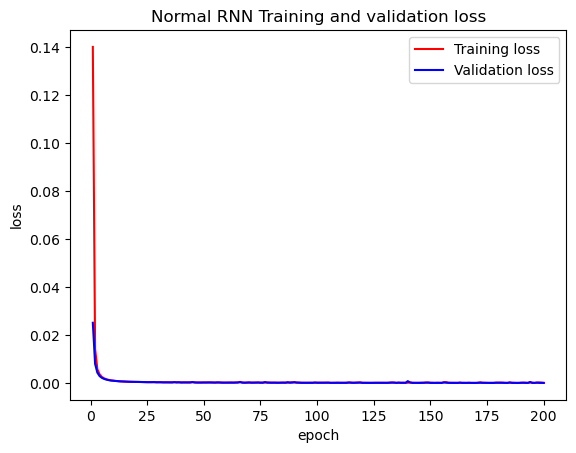

In [104]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

C:\Users\zihaow19\AppData\Local\Temp\ipykernel_16416\2940788247.py:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 0s 2ms/step
(3706, 10, 2)


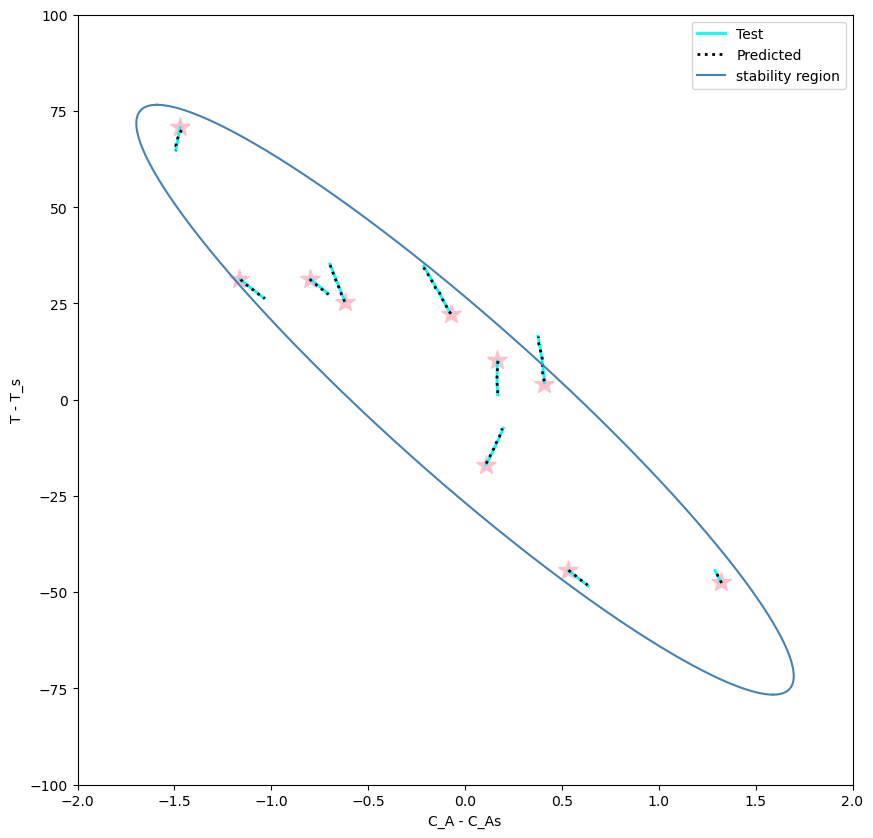

In [105]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass

plt.figure(figsize=(10,10))

# # plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,num_step,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,num_step,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.savefig('rnn_noise_0.pdf')
plt.show()